<h1>MODEL CLEANER VERSION</h1>

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
finaldata = pd.read_csv("finaldata2.csv")

In [4]:
rainfall = finaldata['Rainfall'].values
waterlevel = finaldata['WaterLevel'].values
fwaterlevel = finaldata['FWaterLevel'].values

In [5]:
scaler_rainfall = MinMaxScaler()
scaler_waterlevel = MinMaxScaler()
scaler_fwaterlevel = MinMaxScaler()
rainfall_scaled = scaler_rainfall.fit_transform(rainfall.reshape(-1, 1))
waterlevel_scaled = scaler_waterlevel.fit_transform(waterlevel.reshape(-1, 1))
fwaterlevel_scaled = scaler_fwaterlevel.fit_transform(fwaterlevel.reshape(-1, 1))

In [76]:
def create_narx_dataset(waterlevel, rainfall, fwaterlevel, n_y, n_u):
    X, y = [], []
    for i in range(len(waterlevel) - max(n_y, n_u)):
        y_input = waterlevel[i:i+n_y].flatten()
        u_input = rainfall[i:i+n_u].flatten()
        X.append(np.concatenate((y_input, u_input)))
        y.append(fwaterlevel[i+n_y])
    return np.array(X), np.array(y)

n_y = 24
n_u = 24
X, y = create_narx_dataset(waterlevel_scaled, rainfall_scaled, fwaterlevel_scaled, n_y, n_u)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [78]:
model = Sequential()
model.add(Dense(64, input_dim=n_y + n_u, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='linear'))

In [79]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [80]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
12239/12239 [==============================] - 31s 2ms/step - loss: 3.0343e-05 - mae: 0.0019 - val_loss: 1.4997e-06 - val_mae: 9.0761e-04
Epoch 2/100
12239/12239 [==============================] - 32s 3ms/step - loss: 2.6534e-05 - mae: 0.0017 - val_loss: 2.6202e-06 - val_mae: 0.0013
Epoch 3/100
12239/12239 [==============================] - 31s 3ms/step - loss: 2.4951e-05 - mae: 0.0016 - val_loss: 1.6593e-06 - val_mae: 0.0010
Epoch 4/100
12239/12239 [==============================] - 31s 3ms/step - loss: 2.3756e-05 - mae: 0.0015 - val_loss: 1.7757e-06 - val_mae: 0.0011
Epoch 5/100
12239/12239 [==============================] - 31s 3ms/step - loss: 2.2812e-05 - mae: 0.0014 - val_loss: 4.1943e-06 - val_mae: 0.0017
Epoch 6/100
12239/12239 [==============================] - 31s 3ms/step - loss: 2.2109e-05 - mae: 0.0014 - val_loss: 1.4418e-06 - val_mae: 9.3173e-04
Epoch 7/100
12239/12239 [==============================] - 31s 3ms/step - loss: 2.1624e-05 - mae: 0.0013 - val_loss:

In [81]:
y_pred = model.predict(X_test)

957/957 [==============================] - 3s 3ms/step


In [82]:
y_test_orig = scaler_fwaterlevel.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler_fwaterlevel.inverse_transform(y_pred)

In [83]:
def nash_sutcliffe(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator)

In [84]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
nse = nash_sutcliffe(y_test_orig, y_pred_orig)

print(f"\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R² Score: {r2:.2f}")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")


Model Performance Metrics:
Mean Absolute Error (MAE): 0.14475
R² Score: 0.84
Nash-Sutcliffe Efficiency (NSE): 0.84
Mean Squared Error (MSE): 0.04055
Root Mean Squared Error (RMSE): 0.20136


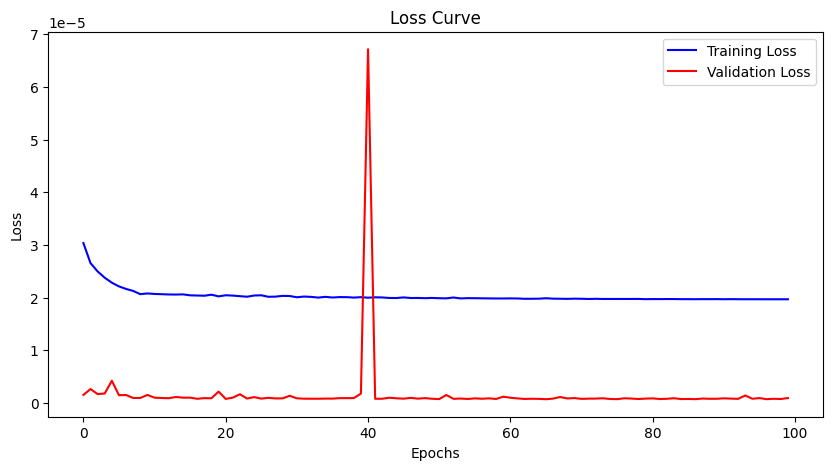

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [86]:
# Print predictions vs actual values
print("\nPredictions vs Actual Values:")
for i in range(min(20, len(y_pred_orig))):  # Print first 20
    print(f"Prediction: {y_pred_orig[i][0]:.3f}, Actual: {y_test_orig[i][0]:.3f}")


Predictions vs Actual Values:
Prediction: -0.795, Actual: -0.670
Prediction: -0.860, Actual: -0.720
Prediction: -0.928, Actual: -0.970
Prediction: -1.045, Actual: -1.290
Prediction: -1.158, Actual: -1.400
Prediction: -1.216, Actual: -1.430
Prediction: -1.264, Actual: -1.450
Prediction: -1.275, Actual: -1.460
Prediction: -1.240, Actual: -1.470
Prediction: -1.188, Actual: -1.470
Prediction: -1.068, Actual: -1.470
Prediction: -0.934, Actual: -1.200
Prediction: -0.868, Actual: -0.930
Prediction: -0.826, Actual: -0.840
Prediction: -0.825, Actual: -0.860
Prediction: -0.919, Actual: -0.970
Prediction: -1.048, Actual: -1.190
Prediction: -1.134, Actual: -1.390
Prediction: -1.217, Actual: -1.420
Prediction: -1.280, Actual: -1.440


In [87]:
model.save('flows_modelv3.h5')

c:\users\mj\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
